In [287]:
import pandas as pd
import pickle 
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant

In [53]:
df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t")

<ipython-input-53-2e85e4964343>:1: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t")


In [190]:
veracityDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2020/labels.csv").rename(columns={"label":"veracityLabel"})
ownershipDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/ownership/infoboxUNCOwnership.csv").rename(columns={"ogName":"source"})
slantDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/politicalSlant/national2020slant.csv").rename(columns={"sourceCleaned":"source", "rating_num":"slant"})
localPoliticsDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/raw/NELAdata/CSVs/politics.csv") 

In [5]:
MODEL_STEM = "/shared/3/projects/newsDiffusion/models/IRTModelling/savedModels/outletEmbeddingsModel/basicModel"

In [7]:
with open(MODEL_STEM + "Embeddings.arr", "rb") as inFile: 
    embedArr = pickle.load(inFile)
    
with open(MODEL_STEM + "EmbeddingsDict.dict", "rb") as inFile: 
    embedDict = pickle.load(inFile)

## run pca and check out axes 

In [49]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(embedArr)

np.random.seed(54859)
pca = PCA(n_components=4)
pcas = pca.fit_transform(scaled_X)

In [132]:
pcDf = pd.DataFrame(pcas, columns=["pc1", "pc2", "pc3","pc4"])

In [180]:
ownerCounts = ownerCounts = ownershipDf[["cleanedOwner", "source"]].groupby("cleanedOwner").agg(len).reset_index().rename(columns={"source":"ownerSize"})

In [194]:
demCols = ["source", "fips", "national", "total_population", "state", "lon", "lat",  "white_pct", "nonwhite_pct"]
demDf = df[demCols].groupby(by="source").first().reset_index()

#merge in a bunch of data from other sources
demDf = pd.merge(demDf, veracityDf, on="source", how="left")
demDf = pd.merge(demDf, slantDf[["source", "slant"]], on="source", how="left")
demDf = pd.merge(demDf, ownershipDf[["source", "cleanedOwner"]], on="source", how="left")
demDf = pd.merge(demDf, ownerCounts, on="cleanedOwner", how="left")
demDf = pd.merge(demDf, localPoliticsDf, on="fips", how="left")

In [195]:
outList = []
for key, val in embedDict.items(): 
    outList.append([key] + list(pcas[val]))

In [196]:
#pcDf that has outlet names merged into it 
pcDf = pd.DataFrame(outList, columns=["source", "pc1", "pc2", "pc3", "pc4"])

In [197]:
pcDf = pd.merge(pcDf, demDf, on="source", how="left")

### Inspect pcas with different variables in our data

Text(0.5, 1.0, 'second two components')

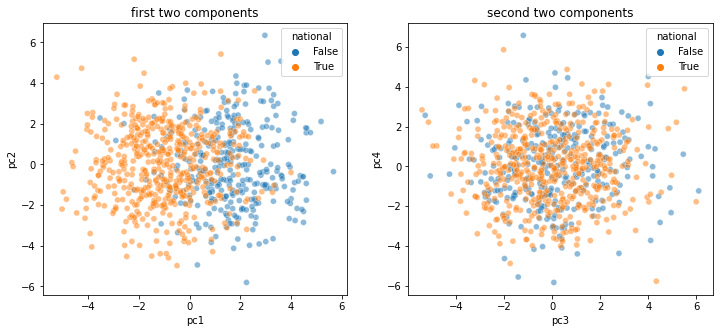

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x="pc1", y="pc2", hue="national", data=pcDf, alpha=.5, ax=axs[0])
axs[0].set_title("first two components")

sns.scatterplot(x="pc3", y="pc4", hue="national", data=pcDf, alpha=.5, ax=axs[1])
axs[1].set_title("second two components")

In [186]:
pcDf["pop_quintiles"] = pd.qcut(pcDf["total_population"], 5) 
popPalette = ['#ffffcc','#c2e699','#78c679','#31a354','#006837']

In [188]:
demDf

,source,national,total_population,state,lon,lat,white_pct,nonwhite_pct,veracityLabel,slant,cleanedOwner,ownerSize
0,21stcenturywire,True,NaN,None,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
1,369news,True,NaN,None,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2,911truthorg,True,NaN,None,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,abcnews,True,NaN,None,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN
4,acnlatitudes,True,NaN,None,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
825,x22report,True,NaN,None,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
826,yahoonews,True,NaN,None,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN
827,yellowspringsnews,False,164325.0,Ohio,-83.886874,39.806449,84.403469,15.596531,NaN,NaN,Yellow Springs News Inc.,1.0
828,yna,True,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'second two components')

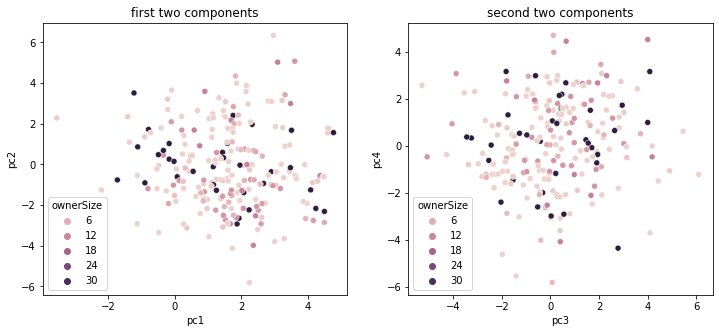

In [189]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x="pc1", y="pc2", hue="ownerSize", data=pcDf, alpha=1, ax=axs[0])
axs[0].set_title("first two components")

sns.scatterplot(x="pc3", y="pc4", hue="ownerSize", data=pcDf, alpha=1, ax=axs[1])
axs[1].set_title("second two components")

In [199]:
pcDf.loc[(pcDf["pc2"] > -.5) & (pcDf["pc1"] < .5) & (pcDf["national"] == False)].head()

,source,pc1,pc2,pc3,pc4,fips,national,total_population,state,lon,lat,white_pct,nonwhite_pct,veracityLabel,slant,cleanedOwner,ownerSize,logodds_Trump20,logodds_Trump16,logodds_Romney12
12,arizonacapitoltimes,-3.534328,2.283088,2.104097,3.066825,4013.0,False,4088549.0,Arizona,-112.074037,33.448377,56.918114,43.081886,NaN,NaN,BridgeTower Media,2.0,-0.044309,0.061324,0.219184
13,arkansastimes,0.239065,0.511313,0.406029,-3.086197,5119.0,False,391806.0,Arkansas,-92.289595,34.746481,53.623222,46.376778,NaN,NaN,Arkansas Times Limited Partnership,1.0,-0.470473,-0.379987,-0.234880
19,cupertinocourier,0.215575,1.686569,0.294140,1.787420,6085.0,False,1885056.0,California,-122.032182,37.322998,33.167078,66.832922,NaN,NaN,Digital First Media,10.0,-1.058321,-1.262174,-0.947175
28,inlandvalleydailybulletin,-0.335300,0.454956,0.508370,-0.834363,6071.0,False,2106754.0,California,-117.650888,34.063344,30.510729,69.489271,NaN,NaN,Digital First Media,10.0,-0.220257,-0.228389,-0.150959
48,keywestcitizen,-1.356397,1.095605,-2.972301,-0.776898,12087.0,False,77150.0,Florida,-81.779987,24.555059,68.324044,31.675956,NaN,NaN,Marshall Amplification PLC (1962-2013) The Mar...,1.0,0.160600,0.143758,-0.008800


## can we predict how liberal a county is using only its publication vectors? 

In [205]:
outList = []
for key, val in embedDict.items(): 
    outList.append((key, embedArr[val,]))

In [208]:
embedDf = pd.DataFrame(outList, columns=["source", "embedding"])

In [210]:
embedDf = pd.merge(embedDf, demDf, on="source", how="left")

In [227]:
embeds = np.array(embedDf["embedding"])

In [266]:
localEmbeds = embedDf[embedDf["national"] == False].dropna(subset=["embedding", "logodds_Trump20"])
features = np.array(localEmbeds["embedding"].to_list())
features = add_constant(features)

In [268]:
labels = localEmbeds["logodds_Trump20"]

In [273]:
features[:,:45].shape

(310, 45)

In [285]:
pcDf

,source,pc1,pc2,pc3,pc4,fips,national,total_population,state,lon,lat,white_pct,nonwhite_pct,veracityLabel,slant,cleanedOwner,ownerSize,logodds_Trump20,logodds_Trump16,logodds_Romney12
0,andalusiastarnews,3.091137,5.027412,1.940896,2.666671,1039.0,False,37729.0,Alabama,-86.483291,31.308504,83.514008,16.485992,NaN,NaN,Boone Newspapers,13.0,1.680054,1.715242,1.347637
1,atmoreadvance,4.361759,-0.555438,-1.804814,2.754320,1053.0,False,37875.0,Alabama,-87.493871,31.023792,60.594059,39.405941,NaN,NaN,Boone Newspapers,13.0,0.795602,0.768921,0.525869
2,thebrewtonstandard,4.003756,-1.690085,-0.110500,-1.352873,1053.0,False,37875.0,Alabama,-87.072192,31.105178,60.594059,39.405941,NaN,NaN,NaN,NaN,0.795602,0.768921,0.525869
3,clantonadvertiser,1.657208,0.377642,-0.913425,-0.614653,1021.0,False,43817.0,Alabama,-86.629426,32.838737,80.610265,19.389735,NaN,NaN,NaN,NaN,1.658727,1.644939,1.411296
4,gadsdenmessenger,1.618717,0.139931,-0.960145,-2.228141,1055.0,False,103363.0,Alabama,-86.006639,34.014264,78.431354,21.568646,NaN,NaN,"McCharthy, Chris",1.0,1.123884,1.130871,0.822089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,bnnbloomberg,-0.921877,-4.387592,-0.335362,-3.071900,NaN,True,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
826,trumptimes,-1.675317,1.612566,-0.557838,-2.561847,NaN,True,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,sustainablepulse,0.818867,-1.915336,-0.440082,-3.417517,NaN,True,NaN,None,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
828,offguardian,-3.522710,-1.314328,0.242729,1.264237,NaN,True,NaN,None,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
model = sm.OLS(labels, features[:,:10]).fit()

In [301]:
model = smf.ols(formula="white_pct ~ pc1 + pc2 + pc3 + pc4", data=pcDf.loc[pcDf["national"] == False, ["pc1", "pc2", "pc3", "pc4", "white_pct"]].dropna())

In [302]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              white_pct   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.566
Date:                Tue, 09 May 2023   Prob (F-statistic):              0.183
Time:                        16:13:25   Log-Likelihood:                -1356.5
No. Observations:                 310   AIC:                             2723.
Df Residuals:                     305   BIC:                             2742.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.6953      1.645     42.369      0.000      66.458      72.932
pc1            1.4594      0.735      1.986      0.048       0.014       2.905
pc2            0.0928      0.556      0.167      0.868      -1.002       1.188
pc3            0.1471      0.584      0.252      0.801      -1.002       1.296
pc4            0.8773      0.580      1.514      0.131      -0.263       2.018
==============================================================================
Omnibus:                       35.384   Durbin-Watson:                   1.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.398
Skew:                          -0.915   Prob(JB):                     2.29e-10
Kurtosis:                       3.291   Cond. No.                         3.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""